## Background

In this notebook, I'll walk through an algorithm I modified (originally created by Claude) to calculate the ratio of lowercase to uppercase letter height from an image of text.

The lowercase height (x-height) is the distance between the top and bottom of lowercase (and uppercase) letters. The uppercase height (cap-height) is the distance from the top of uppercase letters to the bottom of uppercase (and lowercase) letters.

The ratio in question is defined as:

$$\frac{\text{x-height}}{\text{cap-height}}$$

<br>

Calculating this x-height to cap-height ratio is just one of several non-ML baselines I plan to establish before building a neural network to classify typeface categories (e.g., humanist sans, grotesque sans, display, script) from text images. I'm calling this project **TypefaceClassifier** and will continue sharing updates in this blog series over the coming weeks.

![An example of cap-height, x-height and baseline for a line of text](1.png)

In [1]:
#| code-fold: true
#| code-summary: "Show imports"

import cv2
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import os
from os import listdir
from scipy.signal import find_peaks

## Horizontal Projection: Pixel Sum Per Row

The basis of this algorithm is a horizontal projection of the image---in other words, taking the sum of each row's pixels, resulting in an 1-D array of values.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
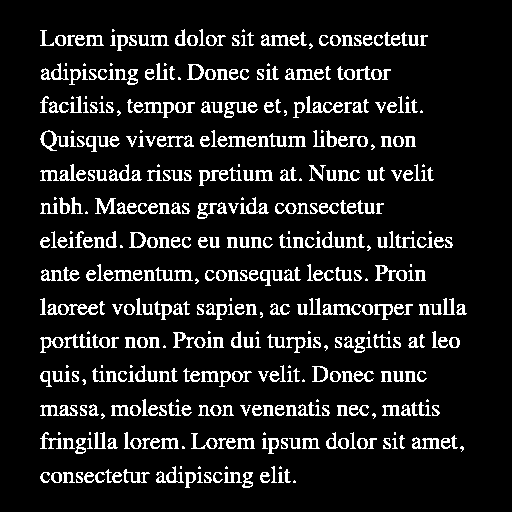

In [19]:
path = 'serif-24px.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary

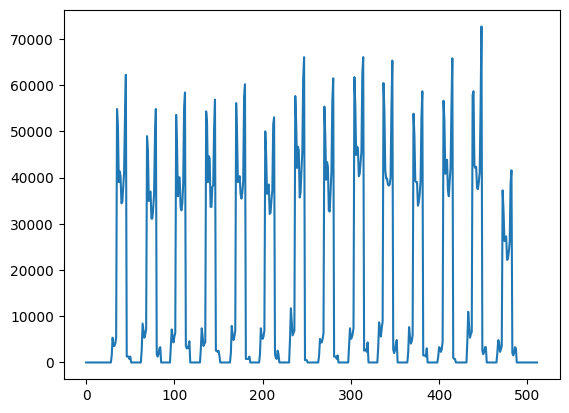

In [20]:
h_proj = np.sum(binary, axis=1)
plt.plot(h_proj);

Superimposing the `h_proj` plot onto the text image reveals that spikes in `h_proj` align with denser white pixels, while troughs correspond to rows with more black pixels.

In [55]:
#| code-fold: true
#| code-summary: "Show code for plotting function"

def img_with_peaks(path):
  # Read the image
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # Calculate horizontal projection
  h_proj = np.sum(binary, axis=1)

  # Create figure and axis
  fig, ax = plt.subplots(figsize=(6, 6))

  # Display the image
  ax.imshow(binary, cmap='gray', aspect='equal')

  # Plot the horizontal projection
  max_proj = np.max(h_proj)
  scaled_proj = h_proj / max_proj * binary.shape[1]  # Scale projection to image width
  ax.plot(scaled_proj, np.arange(len(h_proj)), color='red', linewidth=2, alpha=0.7)

  # Customize the plot
  ax.set_xlim(0, binary.shape[1])
  ax.set_ylim(binary.shape[0], 0)  # Invert y-axis to match image coordinates
  ax.axis('off')  # Remove axes

  # Adjust the plot size and position
  plt.tight_layout()
  plt.show()

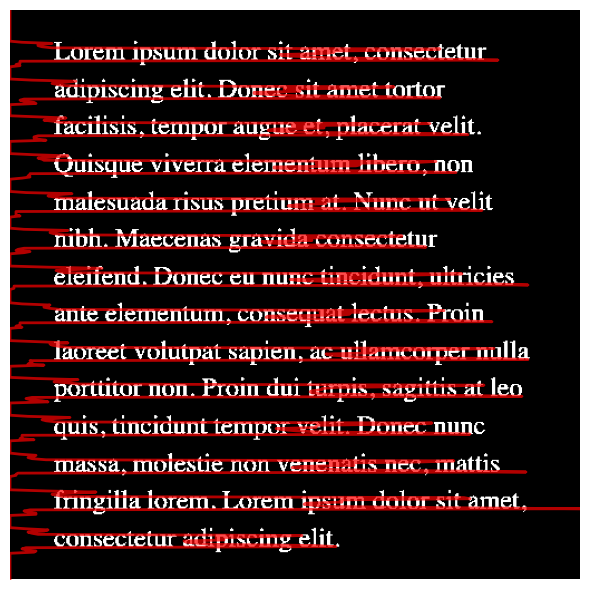

In [56]:
img_with_peaks(path)

## Identifying Letter Heights: Signal Analysis

To determine the pixel heights of lowercase and uppercase letters I need to determine three locations:

- the bottom of the lowercase and uppercase letters (approximately what is called the _baseline_ on which the letters "sit")
- the top of the lower case letters
- the top of the uppercase letters

The image above shows empty rows of black pixels between lines of text, with these rows having a sum of `0`. By capturing groups of non-zero elements in `h_proj` (between the `0`s), I can isolate the row pixel sums for the lines of text. I can then extract the bottom and top of the lowercase and uppercase letters.

### Grouping Non-Zero Elements of an Array

To capture these groups of non-zero elements between `0`s (each group corresponds to a line of text), we can do the following:

Create a boolean `mask` that indicates if each element is non-zero.

In [30]:
mask = h_proj != 0
mask[:5]

array([False, False, False, False, False])

To find the "boundary" of each group (indices where the mask changes from `False` to `True`) we start by adding a `False` to the beginning and end of `mask`---this will capture any non-zero groups that start at the first or last element of `h_proj`:

In [34]:
np.concatenate(([False], mask, [False]))[0], np.concatenate(([False], mask, [False]))[-1]

(False, False)

Next we calculate the difference between consecutive elements in the array:

In [35]:
np.diff(np.concatenate(([False], mask, [False])))[:5]

array([False, False, False, False, False])

Finally, we get the indices of the elements where `h_proj` changes from non-zero to `0` (or `0` to non-zero):

In [42]:
change_indices = np.where(np.diff(np.concatenate(([False], mask, [False]))))[0]
change_indices

array([ 29,  51,  63,  85,  96, 118, 130, 152, 164, 186, 197, 219, 231,
       251, 264, 286, 298, 320, 331, 353, 365, 387, 399, 419, 432, 454,
       466, 488])

In [39]:
# h_proj goes from 0 to non-zero on index 29
# h_proj goes from non-zero to 0 on index 51
h_proj[28], h_proj[29], h_proj[50], h_proj[51]

(0, 1530, 1275, 0)

Now that we have the boundaries of these non-zero groups, we can iterate through them and capture the non-zero elements:

In [43]:
pairs = change_indices.reshape(-1, 2)
pairs

array([[ 29,  51],
       [ 63,  85],
       [ 96, 118],
       [130, 152],
       [164, 186],
       [197, 219],
       [231, 251],
       [264, 286],
       [298, 320],
       [331, 353],
       [365, 387],
       [399, 419],
       [432, 454],
       [466, 488]])

In [48]:
groups = [(h_proj[start:end], np.arange(start, end)) for start, end in pairs]
groups[0] # the h_proj values for the first line of text

(array([ 1530,  5355,  3570,  3570,  4080,  5355, 54825, 51255, 39015,
        41310, 40290, 34425, 34680, 37740, 41055, 52785, 62220,  1275,
         1275,  1275,   765,  1275], dtype=uint64),
 array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 47, 48, 49, 50]))

We'll wrap this up in a function `group_nonzero` for later use:

In [75]:
def group_nonzero(arr):
    # Create a boolean mask for non-zero elements
    mask = arr != 0

    # Find the indices where the mask changes (start and end of groups)
    change_indices = np.where(np.diff(np.concatenate(([False], mask, [False]))))[0]

    # Pair up start and end indices
    pairs = change_indices.reshape(-1, 2)

    # Create groups
    groups = [(arr[start:end], np.arange(start, end)) for start, end in pairs]

    return groups

### Identifying Peaks of Non-Zero Arrays

Now that we have the horizontal projection (row sum of pixels) of each line of text, we can use `scipy.find_peaks` to identify the indices (pixel values) with relatively high concentrations of pixels.

Let's use the first group (line of text) as an example. Running it through `scipy.find_peaks` returns the indices where `scipy` identifies peaks.

In [50]:
peaks, _ = find_peaks(groups[0][0]) # groups[0][0] are the rowsum values
peaks

array([ 1,  6,  9, 16])

There exists a peak on the 1st, 6th, 9th and 16th index. These are relative indices, the absolute indices (across the 512 pixels of the image height) can be captured as so:

In [51]:
indices = groups[0][1][peaks]
indices

array([30, 35, 38, 45])

To illustrate, I'll plot horizontal lines at each of these pixel heights.

The topmost (red) line represents the top of the capital letters. The next (green) line is the top of the lower case letters. The next (blue) line is located at the height of the "bar" in the letter "e". The final (black) line is at the bottom of the lowercase letters.

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
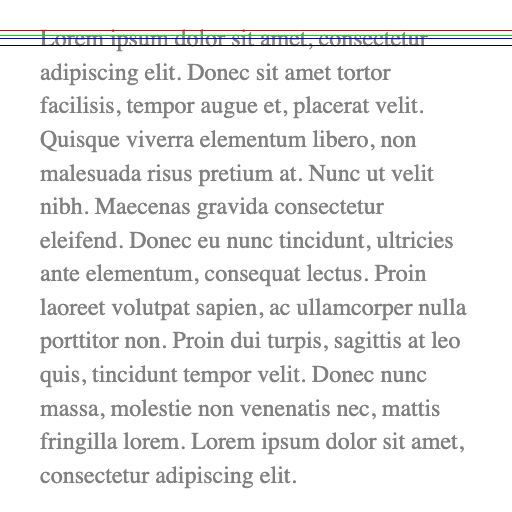

In [54]:
#| code-fold: true
#| code-summary: "Show code to plot lines on image"

img = cv2.imread(path)

colors = [
    (225, 0, 0), # red
    (0, 225, 0), # green
    (0, 0, 225), # blue
    (0, 0,  0 )  # black
]

for i, x in enumerate(indices):
  color_idx = i % 4
  cv2.line(img, [0, x], [512, x], colors[color_idx], 1)

img

The top of the uppercase letters is easy to identify---it's the first peak. To better visualize how we can distinguish between the top and the bottom of the lowercase letters, I'll plot the image, the peaks, and the four horizontal lines all on the same image:

In [135]:
#| code-fold: true
#| code-summary: "Show code for plotting function"

def img_with_peaks(path):
  # Read the image
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # Calculate horizontal projection
  h_proj = np.sum(binary, axis=1)

  # get first line's peaks
  groups = group_nonzero(h_proj)
  peaks, _ = find_peaks(groups[0][0])
  indices = groups[0][1][peaks]

  # Create figure and axis
  fig, ax = plt.subplots(figsize=(6, 6))

  # Display the image
  ax.imshow(binary, cmap='gray', aspect='equal')

  # Draw horizontal lines at specified indices
  for idx in indices:
      ax.axhline(y=idx, color='grey', linewidth=1, alpha=1)

  # Plot the horizontal projection
  max_proj = np.max(h_proj)
  scaled_proj = h_proj / max_proj * binary.shape[1]  # Scale projection to image width
  ax.plot(scaled_proj, np.arange(len(h_proj)), color='red', linewidth=1.25, alpha=1)

  # Customize the plot
  ax.set_xlim(0, binary.shape[1])
  ax.set_ylim(binary.shape[0], 0)  # Invert y-axis to match image coordinates
  ax.axis('off')  # Remove axes

  # Adjust the plot size and position
  plt.tight_layout()
  plt.show()

It's tough to see it clearly on this image, but the top and bottom of the lowercase letters have the two highest peaks of pixel sums.

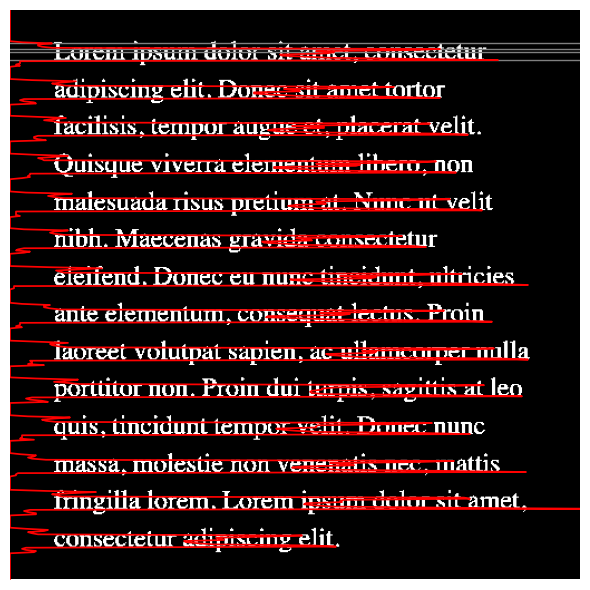

In [136]:
img_with_peaks('serif-24px.png')

You can see it a bit more clearly with larger font---the top of the "u" at the end of the first line corresponds to the second highest blue peak. The bottom of the "u" on the first line corresponds to the highest blue peak.

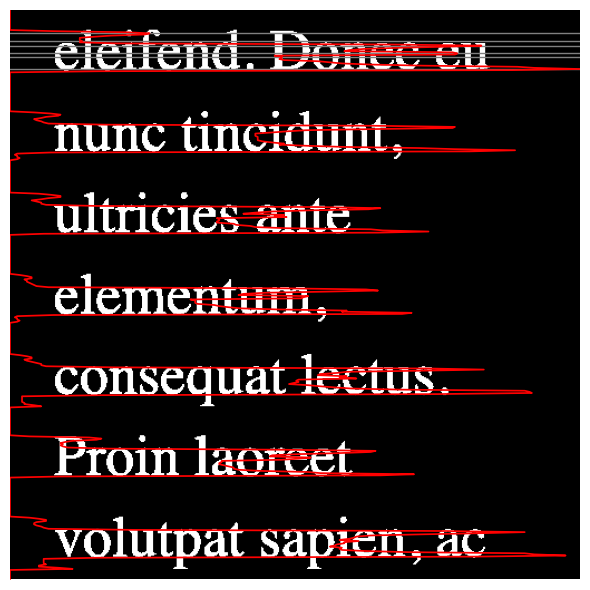

In [137]:
img_with_peaks('serif-52px.png')

To summarize:

- the top of the uppercase letters is the first peak in each line.
- the top and bottom of the lowercase letters are the two-highest peaks in each line.

## Calculating x-height to cap-height Ratio

Given this heuristic, I can calculate the x-height and cap-height (and the ratio between the two) for each line of text:

In [122]:
x_to_cap = []

for group in groups:
  peaks, _ = find_peaks(group[0])

  # top of uppercase letters is the first peak
  cap_top_idx = group[1][peaks[0]]
  cap_top_peak = group[0][peaks[0]]

  # top and bottom of lowercase letters are the two highest remaining peaks
  x_peaks = sorted(zip(group[0][peaks][1:], group[1][peaks][1:]), reverse=True)[:2]
  x_peaks = [el[1] for el in x_peaks]

  # top of lowercase letters is the smaller index from the top
  # bottom of lowercase letters is the larger index from the top
  x_top = np.min(x_peaks)
  x_bottom = np.max(x_peaks)

  # calculate lowercase height (x_height) and uppercase height (cap_height)
  cap_height = x_bottom - cap_top_idx
  x_height = x_bottom - x_top

  # calculate aspect ratio
  ratio = x_height / cap_height
  x_to_cap.append(ratio)

The fourteen lines of text (when the font size is 24px) have a nearly consistent ratio between x-height and cap-height

In [123]:
x_to_cap

[0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6,
 0.6666666666666666]

I can wrap the fully functional code (creating `h_proj` from the image, getting non-zero `groups`, calculating the x-height-to-cap-height ratio for each line) to get the median x-height to cap-height ratio for an image of text:

In [125]:
#| code-fold: true
#| code-summary: "Show code for median_x_to_cap"

def median_x_to_cap(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    final_img = cv2.imread(path)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    h_proj = np.sum(binary, axis=1)

    groups = group_nonzero(h_proj)
    ratios = []

    for group in groups:
        # group[0] are the array values
        # group[1] are the indices
        peaks, _ = find_peaks(group[0]) # `peaks` is the indices of peaks

        if len(peaks) < 3:
            continue  # Skip lines with insufficient peaks

        # top of uppercase letters
        cap_top_idx = group[1][peaks[0]]

        # top and bottom of lowercase letters
        x_peaks = sorted(zip(group[0][peaks][1:], group[1][peaks][1:]), reverse=True)[:2]
        x_peaks = [el[1] for el in x_peaks]

        x_top = np.min(x_peaks)
        x_bottom = np.max(x_peaks)

        # calculate lowercase height (x_height) and uppercase height (cap_height)
        cap_height = x_bottom - cap_top_idx
        x_height = x_bottom - x_top

        # if find_peaks didn't capture top of uppercase letters
        if cap_height == x_height:
          continue

        # calculate aspect ratio
        ratio = x_height / cap_height
        ratios.append(ratio)

    median_ratio = np.median(ratios)

    return median_ratio

I can then try it on different images of the same font (serif). These images have different font sizes and different text of the same font, so they should result in about the same value (0.67) which they do:

In [126]:
median_x_to_cap('serif-24px.png'), \
median_x_to_cap('serif-36px.png'), \
median_x_to_cap('serif-76px.png'),

(0.6666666666666666, 0.6521739130434783, 0.6382978723404256)

Three different images of the same font (display) with different font sizes and texts result in a (somewhat less) consistent median x-height to cap-height ratio:

In [127]:
median_x_to_cap('display-24px.png'), \
median_x_to_cap('display-36px.png'), \
median_x_to_cap('display-76px.png'),

(0.6428571428571429, 0.6190476190476191, 0.6038961038961039)

One limitation of this algorithm is that it results in significantly different ratios for very small or very large font sizes. These ratios should be close to 0.67:

In [130]:
median_x_to_cap('serif-8px.png'), \
median_x_to_cap('serif-330px.png')

(nan, 0.24040133294697189)

These should be close to 0.62:

In [131]:
median_x_to_cap('display-8px.png'), \
median_x_to_cap('display-330px.png')

(nan, 0.875)

For now, I'll move forward with this algorithm knowing that I'll have to constraint the font sizes I use to within 24px and 76px.

## Final Thoughts


Exploring non-ML baselines has significantly expanded my understanding of coding and algorithms. A seemingly simple task, like identifying the tops and bottoms of letters, introduced me to concepts such as horizontal image projection and signal peak detection—ideas I hadn’t encountered before. Calculating the x-height to cap-height ratio is just one of several non-ML baselines I plan to establish before building a neural network to classify typeface categories (e.g., humanist sans, grotesque sans, display, script) from text images. I'm calling this project **TypefaceClassifier** and will continue sharing updates in this blog series over the coming weeks.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).